## Consideration - We only care about the year

Looking at the current `OpenDataset` example, it fetches one year of daily data (one file in the `NEX-GDDP-CMIP6` case) for a few other parameters.

UKCP18 is a bit more painful, as the filenames for a specific set of parameters look like:

```
tas_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc	
tas_rcp85_land-rcm_uk_12km_01_day_19901201-20001130.nc
tas_rcp85_land-rcm_uk_12km_01_day_20001201-20101130.nc
tas_rcp85_land-rcm_uk_12km_01_day_20101201-20201130.nc
tas_rcp85_land-rcm_uk_12km_01_day_20201201-20301130.nc
```

This means if I wanted all the days of `1990`, I would need to select 2 files. I can't just construct a filepath naively as I'd need to know the full filenames/what's available to do so (and we probably don't want to hardcode the filenames that are available)

This kind of removes OPeNDAP as an option as it just expects one filepath for download and you can't really interrogate it.

So we're left with:

* STAC (As we can use the temporal search, which would give us both matching files...)
* FTP (We can glob on the filenames and find matches, then just download multiple if necessary)

This notebook will give the FTP option a go.

In [1]:
# Grab credentials and FTP URL for CEDA
import os

ftp_username = os.environ["CEDA_USERNAME"]
ftp_password = os.environ["CEDA_FTP_PASSWORD"]
ftp_server = os.environ["CEDA_FTP_URL"]

In [2]:
# Login to the FTP server
import ftplib

ftp = ftplib.FTP(ftp_server)
_ = ftp.login(user=ftp_username, passwd=ftp_password)  # Just assigning to _ as the printout for login is annoying!

In [3]:
# These are the properties of the `open_dataset_year` function, so we'll keep expecting them
from typing import Optional

gcm: str = "ukcp18"
scenario: str = "rcp85"
quantity: str = "tas"
year: int = 1990
chunks = None
catalog_url: Optional[str] = None
collection_id: Optional[str] = None

In [4]:
# List all available files for the `tas` variable
tas_path = f"badc/{gcm}/data/land-rcm/uk/12km/{scenario}/01/{quantity}/day/v20190731"
files = ftp.nlst(tas_path)
files

['badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_19901201-20001130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20001201-20101130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20101201-20201130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20201201-20301130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20301201-20401130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20401201-20501130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_20501201-20601130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp8

In [5]:
# List files that year falls within
import re

files_year_falls_within = []
start_end_date_regex = re.compile(r"_(\d{8})-(\d{8})\.nc")
for file in files:
    matches = start_end_date_regex.search(file)
    if matches:
        start_date = int(matches.group(1)[:4])
        end_date = int(matches.group(2)[:4])
        if start_date <= year <= end_date:
            files_year_falls_within.append(file)
files_year_falls_within

['badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_19801201-19901130.nc',
 'badc/ukcp18/data/land-rcm/uk/12km/rcp85/01/tas/day/v20190731/tas_rcp85_land-rcm_uk_12km_01_day_19901201-20001130.nc']

In [6]:
# Load relevant files into xarray dataset and combine them
import io
import xarray

datasets = []

for file in files_year_falls_within:
    with io.BytesIO() as file_in_memory:
        ftp.retrbinary(f"RETR {file}", file_in_memory.write)
        file_in_memory.seek(0)
        datasets.append(xarray.open_dataset(file_in_memory).load())

combined = xarray.combine_by_coords(datasets)
combined

/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


<xarray.Dataset>
Dimensions:                       (ensemble_member: 1, time: 7200,
                                   projection_y_coordinate: 112,
                                   projection_x_coordinate: 82, bnds: 2)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1980-12-01 12:00:00 ... 2000-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
    ensemble_member_id            (ensemble_member) |S27 b'HadREM3-GA705-r001...
    grid_latitude                 (projection_y_coordinate, projection_x_coordinate) float64 ...
    grid_longitude                (projection_y_coordinate, projection_x_coordinate) float64 ...
    month_number                  (time) int32 12 12 12 12 12 ... 11 11 11 11 11
    year                          (time) int32 1980 1980 1980 ... 2000 2000 2000
    yyyymmdd                      (time) |S64 b'19801201                     ...
Dimensions without coordinates: bnds
Data variables:
    tas                           (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 ...
    transverse_mercator           (time) int32 -2147483647 ... -2147483647
    time_bnds                     (time, bnds) object 1980-12-01 00:00:00 ......
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 ...
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 ...
Attributes: (12/15)
    collection:      land-rcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-31T00:00
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      12km
    scenario:        rcp85
    source:          UKCP18 regional realisation from a set of 12 limited-are...
    title:           UKCP18 land projections - 12km regional climate model, m...
    version:         v20190731
    Conventions:     CF-1.5

In [7]:
# Slice out only the year we're interested in
from datetime import datetime

only_year = combined.sel(time=str(year))
only_year

<xarray.Dataset>
Dimensions:                       (ensemble_member: 1, time: 360,
                                   projection_y_coordinate: 112,
                                   projection_x_coordinate: 82, bnds: 2)
Coordinates:
  * ensemble_member               (ensemble_member) int32 1
  * time                          (time) object 1990-01-01 12:00:00 ... 1990-...
  * projection_y_coordinate       (projection_y_coordinate) float64 -1.02e+05...
  * projection_x_coordinate       (projection_x_coordinate) float64 -2.1e+05 ...
    ensemble_member_id            (ensemble_member) |S27 b'HadREM3-GA705-r001...
    grid_latitude                 (projection_y_coordinate, projection_x_coordinate) float64 ...
    grid_longitude                (projection_y_coordinate, projection_x_coordinate) float64 ...
    month_number                  (time) int32 1 1 1 1 1 1 ... 12 12 12 12 12 12
    year                          (time) int32 1990 1990 1990 ... 1990 1990 1990
    yyyymmdd                      (time) |S64 b'19900101                     ...
Dimensions without coordinates: bnds
Data variables:
    tas                           (ensemble_member, time, projection_y_coordinate, projection_x_coordinate) float32 ...
    transverse_mercator           (time) int32 -2147483647 ... -2147483647
    time_bnds                     (time, bnds) object 1990-01-01 00:00:00 ......
    projection_y_coordinate_bnds  (time, projection_y_coordinate, bnds) float64 ...
    projection_x_coordinate_bnds  (time, projection_x_coordinate, bnds) float64 ...
Attributes: (12/15)
    collection:      land-rcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-31T00:00
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      12km
    scenario:        rcp85
    source:          UKCP18 regional realisation from a set of 12 limited-are...
    title:           UKCP18 land projections - 12km regional climate model, m...
    version:         v20190731
    Conventions:     CF-1.5

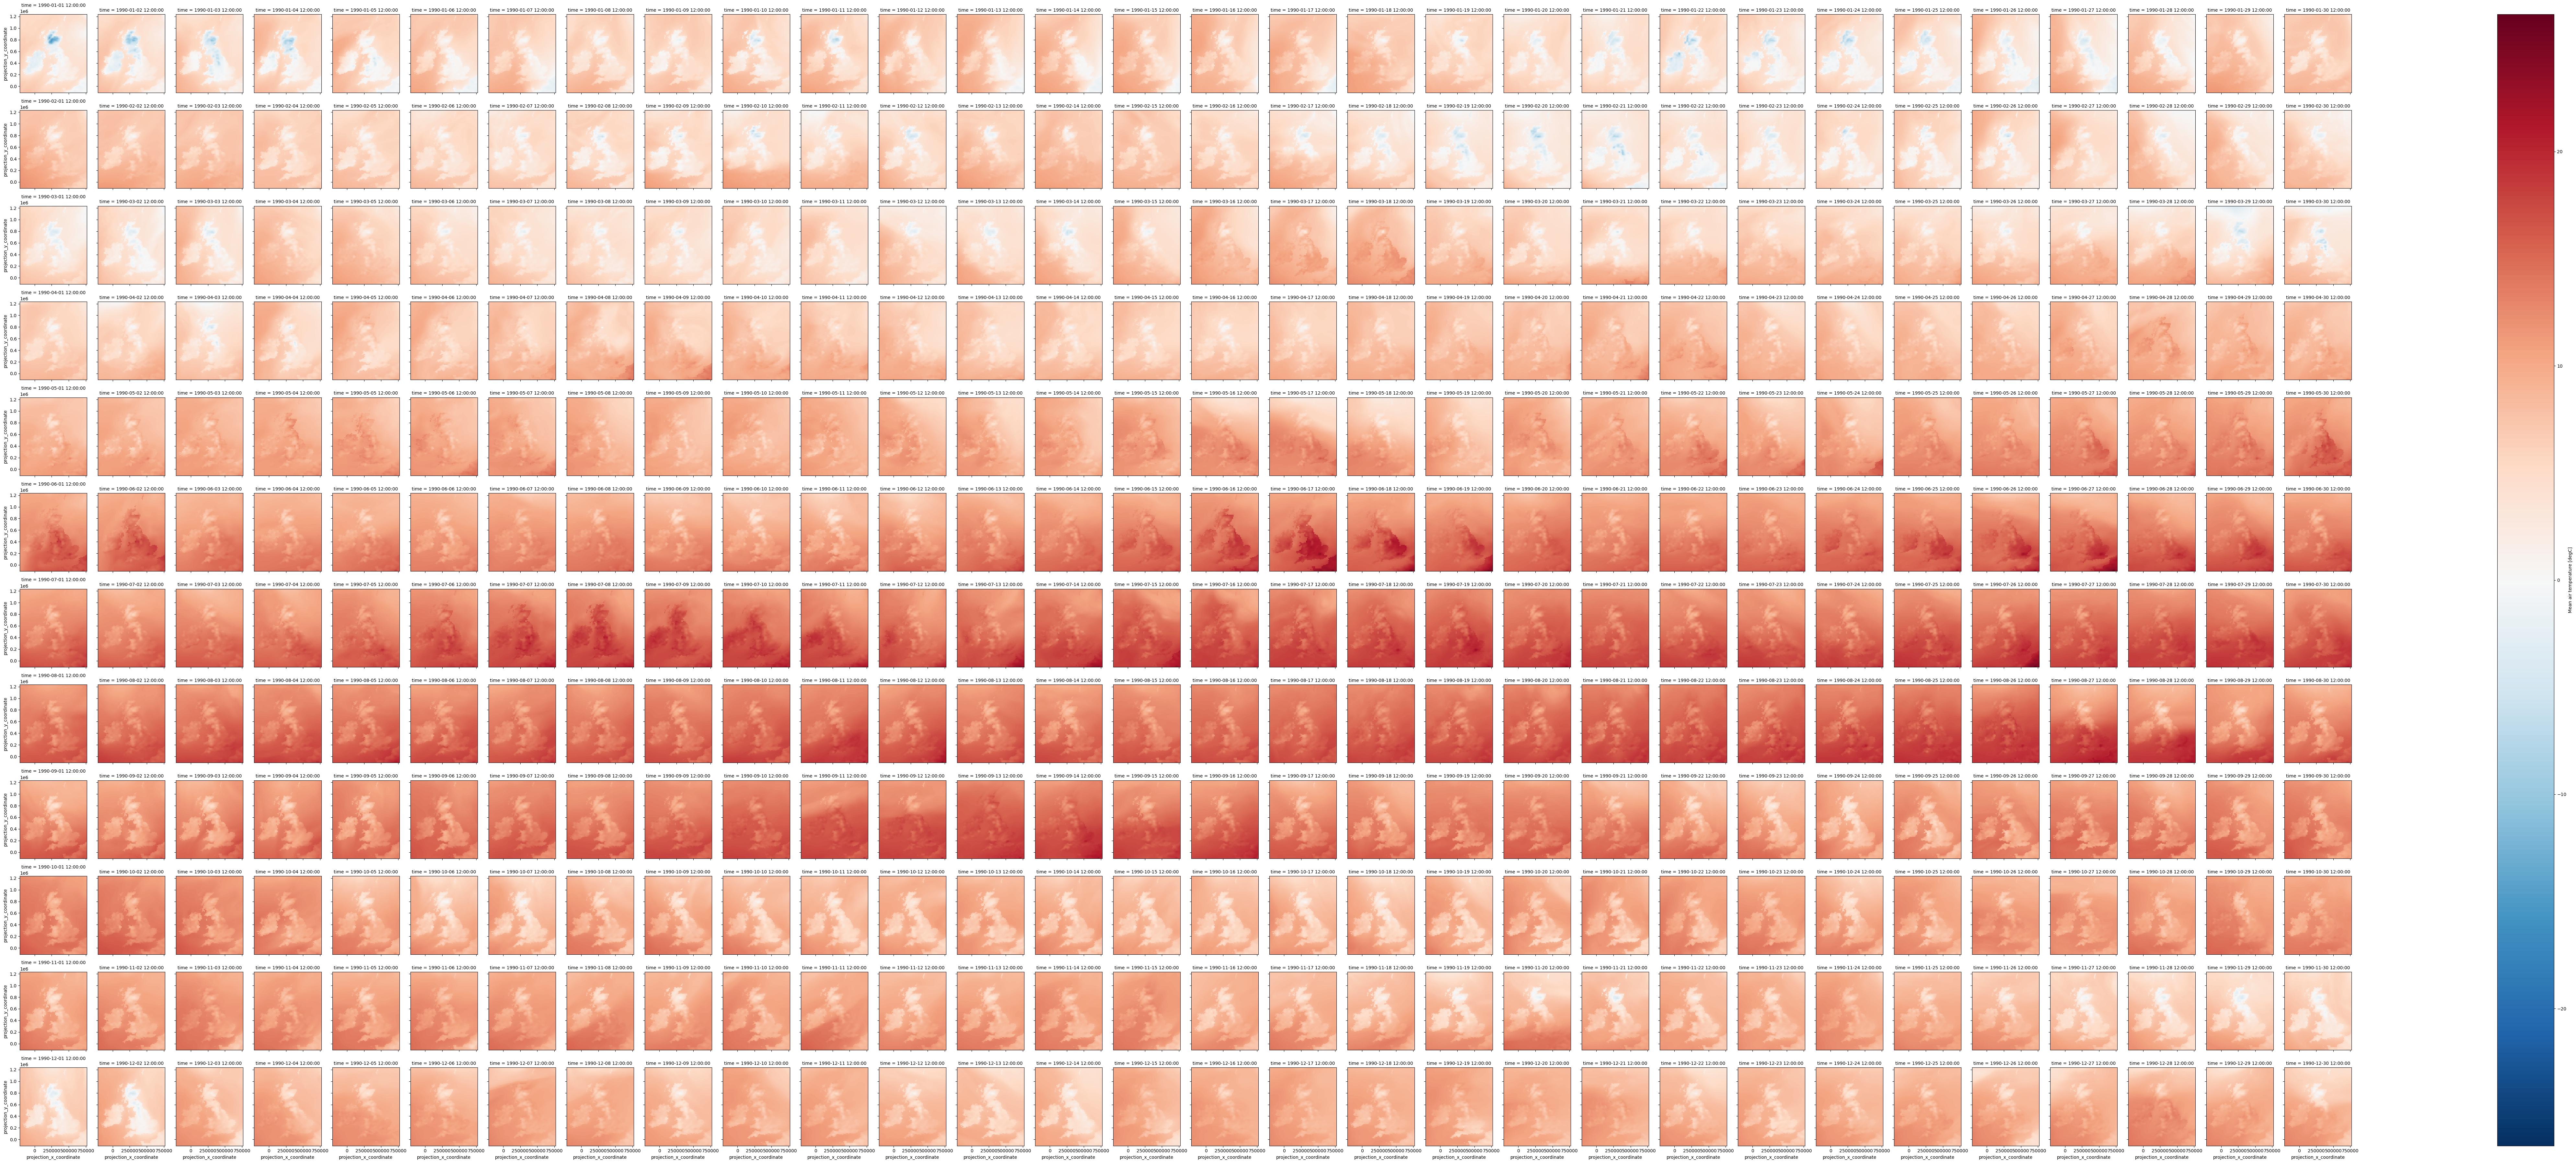

In [8]:
# Plot each day of the year
all_tas_years = only_year.isel(time=slice(0, 360))
all_tas_years["tas"].plot(x="projection_x_coordinate", y="projection_y_coordinate", col="time", col_wrap=30)